In [ ]:
import numpy as np
import cv2
from scipy.constants import c, pi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
# uncomment for inline matlab style interactive figures
# %matplotlib widget

%cd ".."
import simulation as sim
import fft_shift as fft_shift
from utils import calculate_snr, create_mask
import fig_setup

fig_setup.fig_setup() # comment this if using matplotlib widget because they conflict

## No prefilter

#### Useful parameters

In [2]:
# Parameters
save_figs = False

mod_freq = 60 # MHz
wavelength = 940 # nm
k_deg = 90
k = np.deg2rad(k_deg)
calib_offset = 0 # 624.5 # mm
cropX = 0
cropY = 0
sigma=0
gauss_dim = '1d'

center = (100,100)
radius = 100
rotation_angles = np.arange(0,95,5) # used arange(0,94,2) for animation

snrs_intensity = []
snrs_phase = []
recon_intensities = []
recon_phases = []
diff_intensities = []
diff_phases = []
ffts = []
ffts_centered = []
snapshots = []
gt_phases_rotated = []

unambig_dist = (c*0.5)/(mod_freq *1e6)
coeff_to_rad = unambig_dist / (2 * pi)

#### Load data


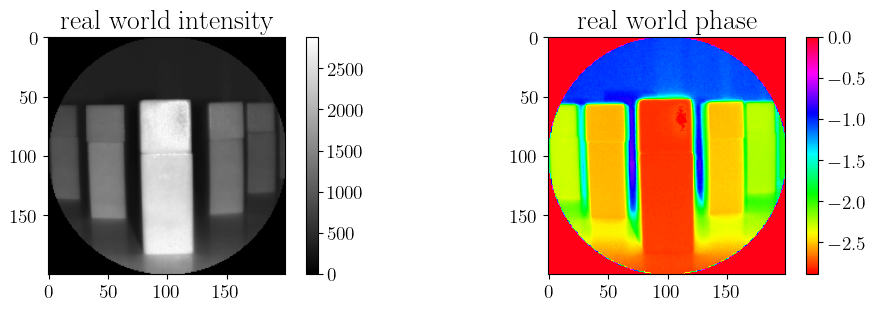

In [3]:
with np.load('data/rotation/dist_amp.npz') as gt_data:
    depth_rw = ((gt_data['dist'] - calib_offset) * 1e-3)[cropY:, cropX:] # divide by 1e3 to get meters
    intensity_rw = gt_data['amp'][cropY:, cropX:]
    
with np.load('data/rotation/phase_data.npz') as phase_data:
    I0_rw = phase_data['phase0'][cropY:, cropX:]
    I90_rw = phase_data['phase90'][cropY:, cropX:]
    I180_rw = phase_data['phase180'][cropY:, cropX:]
    I270_rw = phase_data['phase270'][cropY:, cropX:]
    
phase_rw = create_mask((depth_rw / coeff_to_rad) - pi, center, radius)
height, width = intensity_rw.shape

# show the real world data
fig_rw, axs = plt.subplots(1,2, figsize=(10,3), layout="constrained")
im = axs[0].imshow(intensity_rw, cmap="gray")
axs[0].set_title("real world intensity")
fig_rw.colorbar(im, ax=axs[0])

im = axs[1].imshow(phase_rw, cmap="hsv")
axs[1].set_title("real world phase")
fig_rw.colorbar(im, ax=axs[1])

#### Setup and run simulations with different rotation angles

In [4]:
for i in range(len(rotation_angles)):
    rotation_angle = rotation_angles[i]
    
    # rotate image
    M = cv2.getRotationMatrix2D(((width-1)/2.0,(height-1)/2.0),rotation_angle,1)
    intensity_rw_rotated = create_mask(cv2.warpAffine(intensity_rw,M,(width,height)), center, radius)
    phase_rw_rotated = create_mask(cv2.warpAffine(phase_rw,M,(width,height)), center, radius)
    
    # create a simulation
    fft_shift_sim = fft_shift.FFT_Shift(k, intensity_rw, depth_rw,
                                        omega= 2 * pi * (mod_freq * 1e6),
                                        rotation_angle=rotation_angle)

    # computationally create quad intensity measurements
    fft_shift_sim.create_quad_intensity(method='mlx')

    # compute emulated image intensity
    fft_shift_sim.create_composite_intensity(phase_variation_axis="x", use_Gaussian=gauss_dim, sigma=sigma, method='mlx')

    # calculate the fft shift
    fft_shift_sim.calculate_fft_shifted(phase_variation_axis="x")

    # reconstruct and scale intensity, phase, depth from fft shift
    recon_intensity = 2 * fft_shift_sim.reconstruct_intensity()
    recon_phase = fft_shift_sim.reconstruct_phase() - (pi/2.0)
    
    recon_intensities.append(create_mask(recon_intensity, center, radius))
    recon_phases.append(create_mask(recon_phase, center, radius))
    
    diff_intensities.append(create_mask(intensity_rw_rotated - recon_intensity, center, radius-3))
    snrs_intensity.append(np.mean(intensity_rw_rotated**2)/np.mean((create_mask(intensity_rw_rotated - recon_intensity, center, radius-3))**2))
    
    diff_phases.append(create_mask(phase_rw_rotated - recon_phase, center, radius-3))
    snrs_phase.append(np.mean(phase_rw_rotated**2)/np.mean((create_mask(phase_rw_rotated - recon_phase, center, radius-3))**2))
    
    ffts.append(fft_shift_sim.fft)
    ffts_centered.append(fft_shift_sim.fft_centered)
    
    snapshots.append(fft_shift_sim.composite_image)
    
    gt_phases_rotated.append(phase_rw_rotated)

#### Plot

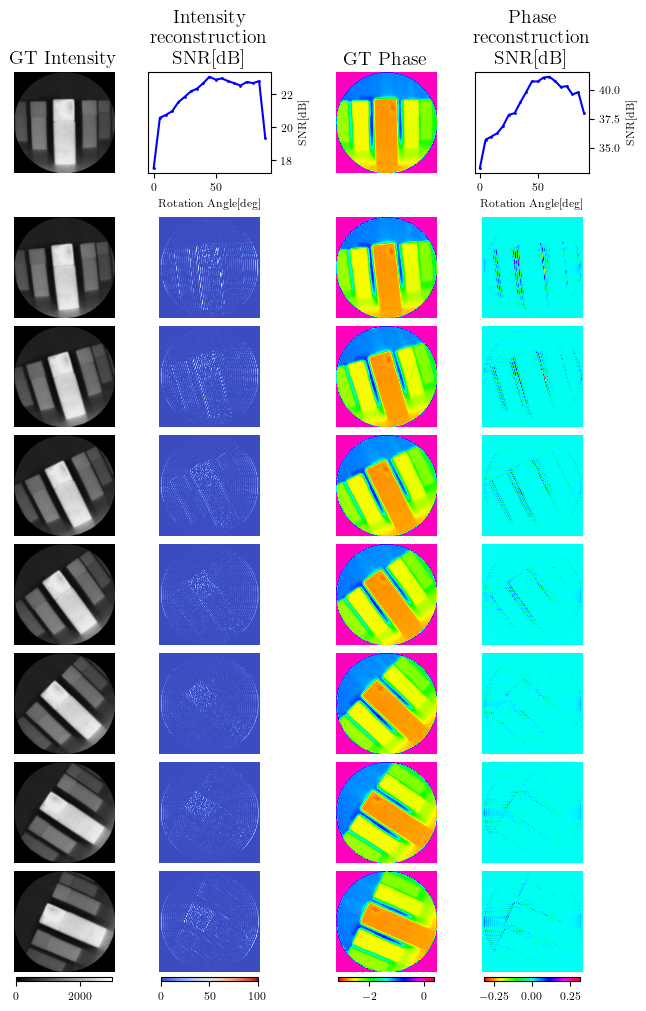

In [5]:
select_angle_indices = np.array([1,3,5,7,9,11,13])

fig_recon, axs = plt.subplots(len(select_angle_indices)+1,4, figsize=(6.5,10), layout="constrained")

for i in range(len(select_angle_indices)):
    theta_plots_limit = len(select_angle_indices)
    # print(select_angle_indices[i], rotation_angles[select_angle_indices[i]])
    
    img = axs[i+1,0].imshow(recon_intensities[select_angle_indices[i]], cmap="gray", vmin=0, vmax=3000)

    axs[i+1,0].axis('off')
    if i+1==theta_plots_limit:
        cbar=fig_rw.colorbar(img, ax=axs[theta_plots_limit,0], shrink=0.7,location='bottom', orientation='horizontal')
        cbar.ax.tick_params(labelsize=8) 
    
    img = axs[i+1,1].imshow(diff_intensities[select_angle_indices[i]], cmap="coolwarm", vmin=0, vmax=100)
    axs[i+1,1].axis('off')
    if i+1==theta_plots_limit:
        cbar=fig_rw.colorbar(img, ax=axs[theta_plots_limit,1], shrink=0.7, location='bottom', orientation='horizontal')
        cbar.ax.tick_params(labelsize=8) 
    
    img = axs[i+1,2].imshow(recon_phases[select_angle_indices[i]], cmap="hsv", vmin=-pi,vmax=pi/8)
    axs[i+1,2].axis('off')
    if i+1==theta_plots_limit:
        cbar=fig_rw.colorbar(img, ax=axs[theta_plots_limit,2], shrink=0.7, location='bottom', orientation='horizontal')
        cbar.ax.tick_params(labelsize=8)
    
    img = axs[i+1,3].imshow(diff_phases[select_angle_indices[i]], cmap="hsv",vmin=-pi/10,vmax=pi/10)
    axs[i+1,3].axis('off')
    if i+1==theta_plots_limit:
        cbar=fig_rw.colorbar(img, ax=axs[theta_plots_limit,3], shrink=0.7,location='bottom', orientation='horizontal')
        cbar.ax.tick_params(labelsize=8) 

final_row_index = 0  

img = axs[final_row_index,0].imshow(intensity_rw, cmap="gray", vmin=0, vmax=3000)
axs[final_row_index,0].set_title("GT Intensity", size=14)
axs[final_row_index,0].axis('off')

img = axs[final_row_index,2].imshow(phase_rw, cmap="hsv", vmin=-pi,vmax=pi/8)
axs[final_row_index,2].set_title("GT Phase", size=14)
axs[final_row_index,2].axis('off')

axs[final_row_index,1].plot(rotation_angles, 10*np.log10(snrs_intensity), "bo-", markersize=1)
axs[final_row_index,1].set_title("Intensity\nreconstruction\nSNR[dB]", fontsize=14)
axs[final_row_index,1].set_xlabel("Rotation Angle[deg]", fontsize=8)
axs[final_row_index,1].set_ylabel("SNR[dB]", fontsize=8, position='right')
axs[final_row_index,1].yaxis.tick_right()
axs[final_row_index,1].yaxis.set_label_position('right')
axs[final_row_index,1].tick_params(labelsize=8)
axs[final_row_index,1].set_aspect(10/0.75, adjustable='box', anchor='C')

axs[final_row_index,3].plot(rotation_angles, 10*np.log10(snrs_phase), "bo-", markersize=1)
axs[final_row_index,3].set_title("Phase\nreconstruction\nSNR[dB]", fontsize=14)
axs[final_row_index,3].set_xlabel("Rotation Angle[deg]", fontsize=8)
axs[final_row_index,3].set_ylabel("SNR[dB]", fontsize=8)
axs[final_row_index,3].yaxis.tick_right()
axs[final_row_index,3].yaxis.set_label_position('right')
axs[final_row_index,3].tick_params(labelsize=8)
axs[final_row_index,3].set_aspect(10/1, adjustable='box', anchor='C')

if save_figs:
    fig_recon.savefig("figures/CVPRfigures/optimal_direction_noprefilter.pdf", bbox_inches='tight') # No prefilter


## Prefilter with optimal sigma=1

In [6]:
sigma=1

snrs_intensity_1 = []
snrs_phase_1 = []
recon_intensities_1 = []
recon_phases_1 = []
diff_intensities_1 = []
diff_phases_1 = []

for rotation_angle in rotation_angles:
    
    # rotate image
    M = cv2.getRotationMatrix2D(((width-1)/2.0,(height-1)/2.0),rotation_angle,1)
    intensity_rw_rotated = create_mask(cv2.warpAffine(intensity_rw,M,(width,height)), center, radius)
    phase_rw_rotated = create_mask(cv2.warpAffine(phase_rw,M,(width,height)), center, radius)
    
    # create a simulation
    fft_shift_sim = fft_shift.FFT_Shift(k,
                                        intensity_rw, depth_rw,
                                        omega = 2 * pi * (mod_freq * 1e6),
                                        rotation_angle=rotation_angle)

    # computationally create quad intensity measurements
    fft_shift_sim.create_quad_intensity(method='mlx')

    # compute emulated image intensity
    fft_shift_sim.create_composite_intensity(phase_variation_axis="x", use_Gaussian=gauss_dim, sigma=sigma, method='mlx')

    # calculate the fft shift
    fft_shift_sim.calculate_fft_shifted(phase_variation_axis="x")

    # reconstruct and scale intensity, phase, depth from fft shift
    recon_intensity = 2 * fft_shift_sim.reconstruct_intensity()
    recon_phase = fft_shift_sim.reconstruct_phase() - (pi/2.0)
    
    recon_intensities_1.append(create_mask(recon_intensity, center, radius))
    recon_phases_1.append(create_mask(recon_phase, center, radius))
    
    diff_intensities_1.append(create_mask(intensity_rw_rotated - recon_intensity, center, radius-3))  
    snrs_intensity_1.append(np.mean(intensity_rw_rotated**2)/np.mean((create_mask(intensity_rw_rotated - recon_intensity, center, radius-3))**2))

    diff_phases_1.append(create_mask(phase_rw_rotated - recon_phase, center, radius-3))
    snrs_phase_1.append(np.mean(phase_rw_rotated**2)/np.mean((create_mask(phase_rw_rotated - recon_phase, center, radius-3))**2))
    

#### Plot

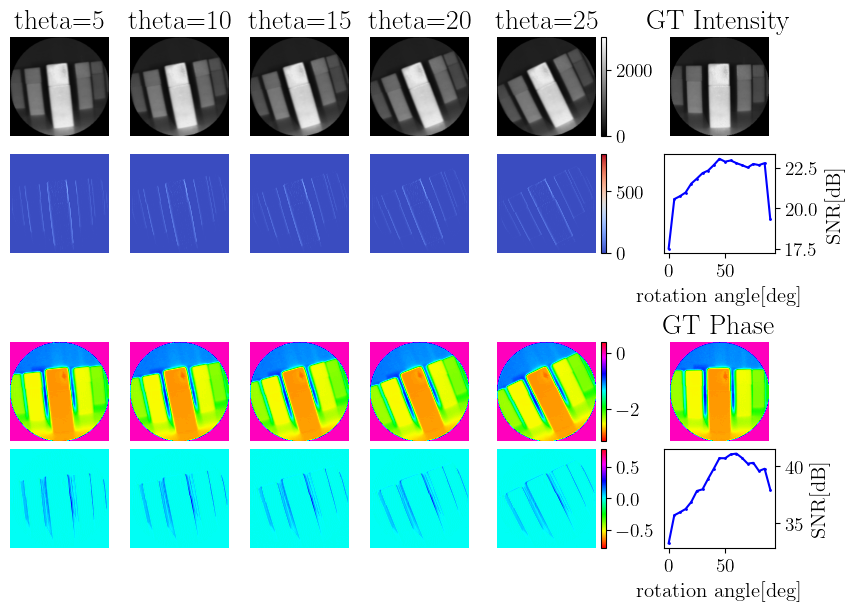

In [7]:
select_angle_indices = np.array([1,2,3,4,5])

fig_recon, axs = plt.subplots(4,len(select_angle_indices)+1, figsize=(8.5,6), layout="constrained")

for i in range(len(select_angle_indices)):
    theta_plots_limit = len(select_angle_indices) - 1
    
    img = axs[0,i].imshow(recon_intensities_1[select_angle_indices[i]], cmap="gray", vmin=0, vmax=3000)
    axs[0,i].set_title("theta={}".format(rotation_angles[select_angle_indices[i]]))
    axs[0,i].axis('off')
    if i==theta_plots_limit:
        cbar=fig_rw.colorbar(img, ax=axs[0,theta_plots_limit])

    img = axs[1,i].imshow(diff_intensities_1[select_angle_indices[i]], cmap="coolwarm", vmin=0, vmax=800)
    axs[1,i].axis('off')
    if i==theta_plots_limit:
        cbar=fig_rw.colorbar(img, ax=axs[1,theta_plots_limit])

    img = axs[2,i].imshow(recon_phases_1[select_angle_indices[i]], cmap="hsv", vmin=-pi,vmax=pi/8)
    axs[2,i].axis('off')
    if i==theta_plots_limit:
        cbar=fig_rw.colorbar(img, ax=axs[2,theta_plots_limit])
    
    img = axs[3,i].imshow(diff_phases_1[select_angle_indices[i]], cmap="hsv",vmin=-pi/4,vmax=pi/4)
    axs[3,i].axis('off')
    if i==theta_plots_limit:
        cbar=fig_rw.colorbar(img, ax=axs[3,theta_plots_limit])
    

img = axs[0,-1].imshow(intensity_rw, cmap="gray", vmin=0, vmax=3000)
axs[0,-1].set_title("GT Intensity")
axs[0, -1].axis('off')

img = axs[2,-1].imshow(phase_rw, cmap="hsv", vmin=-pi,vmax=pi/8)
axs[2,-1].set_title("GT Phase")
axs[2, -1].axis('off')

axs[1,-1].plot(rotation_angles, 10*np.log10(snrs_intensity), "bo-", markersize=1, label="1d Gaussian")
axs[1,-1].set_xlabel("rotation angle[deg]")
axs[1,-1].set_ylabel("SNR[dB]", position='right')
axs[1, -1].yaxis.tick_right()
axs[1, -1].yaxis.set_label_position('right')
extent = axs[1,-1].get_window_extent().transformed(fig_recon.dpi_scale_trans.inverted())

axs[3,-1].plot(rotation_angles, 10*np.log10(snrs_phase), "bo-", markersize=1, label="1d Gaussian")
axs[3,-1].set_xlabel("rotation angle[deg]")
axs[3,-1].set_ylabel("SNR[dB]")
axs[3, -1].yaxis.tick_right()
axs[3, -1].yaxis.set_label_position('right')
extent = axs[3,-1].get_window_extent().transformed(fig_recon.dpi_scale_trans.inverted())

if save_figs:
    fig_recon.savefig("figures/CVPRfigures/optimal_direction_prefilter1.pdf", bbox_inches = 'tight') # prefilter=1


### Generate animation frames

In [8]:
for i in tqdm(range(rotation_angles.shape[0])):
    fig_rotate, axs = plt.subplots(2,3, figsize=(8,6), layout='constrained')
    fig_rotate.suptitle("{}$^\\circ$ rotation, no prefiltering".format(rotation_angles[i]))

    axs[0,0].imshow(gt_phases_rotated[i], cmap='hsv', vmin=-pi, vmax=pi/8)
    axs[0,0].set_title("Ground truth phase")
    axs[0,1].imshow(recon_phases[i], cmap='hsv', vmin=-pi, vmax=pi/8)
    axs[0,1].set_title("Reconstructed phase")
    axs[0,2].imshow(diff_phases[i], cmap='hsv', vmin=-pi/10, vmax=pi/10)
    axs[0,2].set_title("Difference")

    axs[1,0].imshow(snapshots[i], cmap='magma')
    axs[1,0].set_title("Snapshot")
    axs[1,1].imshow(np.abs(ffts[i]), cmap='magma', norm=SymLogNorm(linthresh=1e1, vmin=0, vmax=1e7))
    axs[1,1].set_title("Snapshot FFT")
    axs[1,2].imshow(np.abs(ffts_centered[i]), cmap='magma', norm=SymLogNorm(linthresh=1e1, vmin=0, vmax=1e7))
    axs[1,2].set_title("Centered FFT")


    for a in axs.flatten():
        a.axis('off')
    
    if i < 10:    
        fig_rotate.savefig('figures/animation/rotation_angle/rotation_angle_0{}.png'.format(i), bbox_inches='tight')
    else:
        fig_rotate.savefig('figures/animation/rotation_angle/rotation_angle_{}.png'.format(i), bbox_inches='tight')
        
    plt.close()

100%|███████████████████████████████████████████| 47/47 [00:10<00:00,  4.52it/s]
